In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert, butter, filtfilt, freqz, lfilter
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from sklearn.linear_model import Lasso
import itertools
import os
import h5py

from scipy.linalg import toeplitz, circulant

from scipy.io import loadmat

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import torch
import plotly.graph_objects as go
from io import BytesIO
import plotly.io as pio
from ipywidgets import interactive, Layout, FloatSlider, IntSlider, VBox, HBox, interactive_output,ToggleButton,Dropdown,Button
import re
import mat73
import torch.nn.functional as F
# # Manually run garbage collection
! nvidia-smi


# def butter_bandpass(lowcut, highcut, fs, order=5):
#     b, a = butter(order, [lowcut, highcut], fs=fs, btype='band')
#     return b, a

# def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
#     b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#     y = filtfilt(b, a, data, axis=1)
#     return y

%matplotlib inline

Sat Jul 26 17:15:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.80                 Driver Version: 576.80         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5080      WDDM  |   00000000:02:00.0  On |                  N/A |
|  0%   47C    P8             18W /  360W |    2256MiB /  16303MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Parameters

In [2]:
Fc      = 15.625e6                            
Fs      = 4*Fc                       
ntime   = 3072
dt      = 1/Fs
rtrans  = 30            # mm
b       = 1e-3          # m, half width trans
beta    = 1e-3          # m, half height trans
device  ='cuda'
imsz    = 86 # leaf use 86 
r       = 1.0
rix, riy, riz = np.meshgrid(
    np.linspace(-r, r, imsz),
    np.linspace(-r, r, imsz),
    np.linspace(-r, r, imsz), # - 0.5 # for invivo PalmRightHand2
    indexing='ij'
)
rix = torch.tensor(rix, dtype=torch.float32).to(device)
riy = torch.tensor(riy, dtype=torch.float32).to(device)
riz = torch.tensor(riz, dtype=torch.float32).to(device)

# rotate along z direction


global volPA
volPA = None

In [3]:
# # image rotation if needed
# theta = -np.pi / 4  # 45 degrees
# cos_theta = np.cos(theta)
# sin_theta = np.sin(theta)

# # Perform 45-degree rotation in the xy-plane
# rix_rot = cos_theta * rix - sin_theta * riy
# riy_rot = sin_theta * rix + cos_theta * riy

# # Convert the rotated coordinates back to tensors
# rix = (rix_rot).to(device)
# riy = (riy_rot).to(device)

# # The z-coordinates remain unchanged
# riz = riz

In [4]:


def hilbert_torch(signal, dim=-1):
    """
    Computes the Hilbert transform of a multi-dimensional signal using the Fast Fourier Transform (FFT).
    This implementation mimics MATLAB's hilbert function.

    Args:
        signal (torch.Tensor): The input n-dimensional tensor (signal) to transform.
        dim (int): The dimension along which to compute the Hilbert transform.

    Returns:
        torch.Tensor: The complex-valued Hilbert transform (analytic signal) of the input signal.
    """
    # Ensure the input is a tensor
    if not isinstance(signal, torch.Tensor):
        raise ValueError("Input must be a PyTorch tensor.")

    # Get the shape of the input tensor
    shape = signal.shape

    # Move the tensor to GPU if available
    device = signal.device
    N = signal.size(dim)

    # Compute the FFT along the specified dimension
    transforms = torch.fft.fft(signal, dim=dim)

    # Create a mask to apply to the FFT results
    mask = torch.zeros(N, dtype=torch.complex64, device=device)
    mask[0] = 1  # DC component remains unchanged
    mask[1:N//2] = 2  # Double the amplitude for positive frequencies
    if N % 2 == 0:
        mask[N//2] = 1  # Include the Nyquist frequency if even

    # Apply the mask to the FFT of the signal
    transforms = transforms * mask

    # Compute the inverse FFT to get the Hilbert transform (analytic signal)
    hilbert_signal = torch.fft.ifft(transforms, dim=dim)

    return hilbert_signal

# def fk_filter(test):
#     ntime = test.shape[0]
#     nsensor = test.shape[1]
#     nseg = 4
#     #
#     test = test.reshape(ntime,nseg,-1).permute(1,2,0)
#     testft = torch.fft.fftshift(torch.fft.fft2(test),dim=(1,2))
#     testft[:,32,:] = 0

#     rec = torch.fft.ifft2(torch.fft.ifftshift(testft,dim=(1,2))).permute(2,0,1).reshape(ntime,nsensor).real

#     return rec

In [5]:
# from VRS
import struct
def load_vrs(fileName,nt,ntx=28,verbose=False):
    headerInfo = {}
    with open(fileName, 'rb') as file_obj:
        # Read Version (uint16)
        version = struct.unpack('3B', file_obj.read(3))[0]  # Read 2 bytes for uint16
        headerInfo['version'] = version
        # Compression (uint8)
        compression = struct.unpack('B', file_obj.read(1))[0]
        headerInfo['compression'] = compression

        timetagflag = struct.unpack('B', file_obj.read(1))[0]
        headerInfo['timetagflag'] = timetagflag

    #     so no timetagflag
        if timetagflag == 1:
            time_tag = struct.unpack('6B', file_obj.read(6))  # 6 bytes: Sec, Min, Hour, Day, Month, Year
            headerInfo['time_tag'] = time_tag

        studyidlength = struct.unpack('<Q', file_obj.read(8))[0]
        headerInfo['studyidlength'] = studyidlength
        studyid = file_obj.read(studyidlength).decode('utf-8')
        headerInfo['studyid'] = studyid

        sampleidlength = struct.unpack('<Q', file_obj.read(8))[0]
        headerInfo['sampleidlength'] = sampleidlength
        sampleid = file_obj.read(sampleidlength).decode('utf-8')
        headerInfo['sampleid'] = sampleid

        commentlength = struct.unpack('<Q', file_obj.read(8))[0]
        headerInfo['commentlength'] = commentlength
        comment = file_obj.read(commentlength).decode('utf-8')
        headerInfo['comment'] = comment

        dim = struct.unpack('4Q', file_obj.read(32))  # 4 uint64 values
        headerInfo['dim'] = dim

        numdatapoints = struct.unpack('Q', file_obj.read(8))[0]
        headerInfo['numdatapoints'] = numdatapoints

        #print(file_obj.read(1))
        datatypes = struct.unpack('B', file_obj.read(1))[0]
        headerInfo['datatypes'] = datatypes

        # not sure what is this dtypes version
        # in the actual extraction, it shows S16, probably signed 16

        data = np.frombuffer(file_obj.read(numdatapoints * 2), dtype='<h')  # 2 bytes per int16
        data2 = np.reshape(data ,(dim[1],ntx*3072)) #  the initial data is flattened time with the amount of TX, for each sensor, they store the data in 4096 format
        data2 = np.reshape(data2[:,:ntx*nt],(dim[1],ntx,nt))

    if verbose:
        for key in headerInfo.keys():
            print(key,headerInfo[key])
    return data2

def load_vrs_data(pathFileName,datanum=20):
    data = load_vrs(pathFileName,3072,datanum,verbose=False)
    data = data.transpose(1,2,0)
    data = np.expand_dims(data,-1)
    # data should be (nsensor, ntime)
    # play around here 
    return data



In [6]:
def process_sensor_PA(idx_rcv,datPAraw,sensor_pos_local,cPA,start_time_PA,params,with_directivity=False):
    # Receive
    dPos_rcv = sensor_pos_local[:, idx_rcv]
    phys_dist_rcv = torch.sqrt((rix - dPos_rcv[0]) ** 2 + (riy - dPos_rcv[1]) ** 2 + (riz - dPos_rcv[2]) ** 2)

    time_points_distPA = ((phys_dist_rcv) * 1e-3 / cPA) * Fs - start_time_PA # this is the time

    phase_rotator = torch.exp(-1j * 2 * torch.pi * (phys_dist_rcv * 1e-3 / cPA) * Fc)
    
    linear_factor = (time_points_distPA -  torch.floor(time_points_distPA))
    data_slicePA = (datPAraw[idx_rcv, torch.floor(time_points_distPA).to(torch.int32)] 
                    + linear_factor*(
                        datPAraw[idx_rcv, torch.ceil(time_points_distPA).to(torch.int32)]
                        - datPAraw[idx_rcv, torch.floor(time_points_distPA).to(torch.int32)]
                    ))
    
    if with_directivity:
        D = 1 # directivity funciton is yet to be implemented, refer to another works for directivity function
        return D * data_slicePA
    else:
        return data_slicePA

In [7]:
def depthImage(volume,idx,isShow=False,isReturn=False):

    # Step 1: Project depth data to create a depth map
    depth_map = np.argmax(volume, axis=2)

    # Step 2: Normalize the depth data for color mapping
    # depth_normalized = (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map))
    depth_normalized = depth_map / imsz
    depth_normalized = 1 - abs(depth_normalized*2 - 1)

    # Step 3: Create an intensity map for coloring
    # Use the maximum intensity along the depth (z-axis) for each (x, y) location
    intensity_map = np.max(volume, axis=2)

    # Normalize intensity values to range [0, 1]
    intensity_normalized = (intensity_map - np.min(intensity_map)) / (np.max(intensity_map) - np.min(intensity_map))

    # Step 5: Apply the 'hot' colormap to the depth map using plt.get_cmap
    colormap = plt.get_cmap('hot')
    depth_colored = colormap(depth_normalized)

    # Step 6: Scale the colormap by intensity (for darkness effect)
    depth_colored[..., :3] = depth_colored[..., :3] * intensity_normalized[..., np.newaxis]  # Apply intensity to RGB channels

    
    
    # depth_colored = np.flipud(depth_colored)
    # depth_colored = np.rot90(depth_colored)
    if isReturn:
        return depth_colored
    
    
    fig, ax = plt.subplots()
    im = ax.imshow(depth_colored,cmap='hot')

    # Add the colorbar with the same 'hot' colormap
    cbar = fig.colorbar(im, ax=ax, cmap='hot')  # Explicitly set the colormap for the colorbar
    cbar.set_label('Depth (mm), Surface @ 0 mm ')  # Customize the label as needed
    cbar.set_ticks(np.linspace(0,1,5))  # Set the tick positions
    cbar.set_ticklabels([f"{x:.1f}" for x in np.linspace(-r,-0.45,5)])  # Set the tick positions minus offset of surface location by US
    # Display the plot
    # ax.axis('off')  # Turn off axis
    plt.xticks(np.linspace(0,imsz,5),[f"{x:.1f}" for x in np.linspace(-r,r,5)])
    plt.yticks(np.linspace(0,imsz,5),[f"{x:.1f}" for x in np.linspace(r,-r,5)])

    ax.text(0.95, 0.05, f"{(idx * (1/20)):.2f} s", color='white', fontsize=12, ha='right', va='bottom',
            transform=ax.transAxes, bbox=dict(facecolor='black', alpha=0.5))

    if isShow:
        plt.show()
    else:
        plt.savefig(os.path.expanduser(f'~/Documents/images/{idx}.png'),bbox_inches='tight')
        plt.close()
    

def SliceImageZ(slice,idx,vmin=0,vmax=1,isShow=False):
    
    fig, ax = plt.subplots()
    slice = np.rot90(slice)
    im = ax.imshow(slice,cmap='hot',vmin=vmin,vmax=vmax)

    # Add the colorbar with the same 'hot' colormap
    cbar = fig.colorbar(im, ax=ax, cmap='hot')  # Explicitly set the colormap for the colorbar
    # cbar.set_label('Depth (mm), Surface @ 0 mm ')  # Customize the label as needed
    # cbar.set_ticks(np.linspace(0,1,5))  # Set the tick positions
    # cbar.set_ticklabels([f"{x:.1f}" for x in np.linspace(-r,-0.45,5)])  # Set the tick positions minus offset of surface location by US
    # Display the plot
    # ax.axis('off')  # Turn off axis
    plt.xticks(np.linspace(0,imsz,5),[f"{x:.1f}" for x in np.linspace(-r,r,5)])
    plt.yticks(np.linspace(0,imsz,5),[f"{x:.1f}" for x in np.linspace(r,-r,5)])

    ax.text(0.95, 0.05, f"{(idx * (1/20)):.2f} s", color='white', fontsize=12, ha='right', va='bottom',
            transform=ax.transAxes, bbox=dict(facecolor='black', alpha=0.5))

    if isShow:
        plt.show()
    else:
        plt.savefig(os.path.expanduser(f'~/Documents/images/{idx}.png'),bbox_inches='tight')
        plt.close()
    

In [8]:
def fk_filter(test):
    ntime = test.shape[0]
    nsensor = test.shape[1]
    nseg = 4
    #
    test = test.reshape(ntime,nseg,-1).transpose(1,2,0)
    testft = np.fft.fftshift(np.fft.fft2(test),axes=(1,2))
    testft[:,32,:] = 0

    rec = np.fft.ifft2(np.fft.ifftshift(testft,axes=(1,2))).transpose(2,0,1).reshape(ntime,nsensor).real

    return rec

In [9]:
### All helpers function stored here
def get_psf(x):
    mu = abs(np.fft.fft(hilbert_torch(x,1))).T.mean(-1)
    psf = np.fft.fftshift(np.fft.ifft(mu))
    return psf

# the wiener conv solve the deconvolution for x given 
# the PSF constructed as matrix Ar (real) & Ai (imaginary)
# the output is a complex number solution of the deconvolved signal
def wiener_conv(y,h,method='LASSO',noise_estimate=0,reg_params=1e-6):
    # need to normalize the data first
    # y is all real data

    if method == 'LASSO':
        kernel  = np.fft.fftshift(h)
        G       = circulant(kernel)

        yinp    = y.numpy()
        yinpmax = yinp.max(0)
        yinp    = yinp / yinpmax
        solReal =  Lasso(alpha=reg_params,max_iter=100000).fit(G.real,yinp).coef_.T * yinpmax

        yinp    = y.numpy()
        yinpmax = yinp.max(0)
        yinp    = yinp / yinpmax
        solImag =  Lasso(alpha=reg_params,max_iter=100000).fit(G.imag,yinp).coef_.T * yinpmax

        sol = solReal + 1j*solImag

        return sol.T

        
    if method == 'FREQ':
        y_max = y.clone().max()
        y     = y / y_max
        predenum= (abs(np.fft.fft(h) )**2)+ 1e-2
        denum   = (abs(np.fft.fft(h))**2 + reg_params * ( abs(np.fft.fft(noise_estimate))**2 / predenum))
        denum   = denum + 1e-2

        M       = np.fft.fft(h).conj() / denum
        PAr     = np.fft.ifftshift(np.fft.ifft( (np.fft.fft(y.T) * M) ),1)

        PAr     = PAr * y_max.numpy() / abs(PAr).max()

        final_result = PAr

    if method == "TIKHONOV":
        y_raw = y.clone()
        y_max = y.max(0).values
        y     = y / (y_max)
        psf_r = np.real(np.fft.fftshift(h))
        psf_i = np.imag(np.fft.fftshift(h))

        # construct shif matrix
        Ar = toeplitz(psf_r,psf_r)
        Ai = toeplitz(psf_i,psf_i)

        x_hat_r = np.linalg.inv(Ar.T @ Ar + np.eye(Ar.shape[0])*reg_params) @ Ar.T @ y.numpy()
        x_hat_i = np.linalg.inv(Ai.T @ Ai + np.eye(Ai.shape[0])*reg_params) @ Ai.T @ y.numpy()

        x_hat = x_hat_r + 1j*x_hat_i

        x_hat = (x_hat.T)
        final_result = x_hat * y_max.unsqueeze(-1).numpy()

    return final_result


In [10]:
# interpolate the snesor, named "sensor_pos_interp"
sensor_pos      = np.load("./hardware/transducer_coordinates.npy").T* 1e3 # make mm
sensor_pos      = torch.tensor(sensor_pos,dtype=torch.float).to(device)
# Initialize the output tensor for interpolated positions
sensor_pos_p5 = torch.zeros_like(sensor_pos,dtype=torch.float)

# Loop through each pair of consecutive sensors
for i in range(sensor_pos.shape[1] - 1):
    # Get the vectors for the current and next sensor
    v0 = sensor_pos[:, i] / rtrans
    v1 = sensor_pos[:, i + 1] / rtrans

    # Calculate the angle between the vectors in spherical coordinates (azimuth and elevation)
    v0_angle = torch.acos(v0[2])  # Elevation angle for v0 (angle from the z-axis)
    v1_angle = torch.acos(v1[2])  # Elevation angle for v1

    # Interpolate the elevation angle
    vp5_angle = (v0_angle + v1_angle) / 2
    zp5 = rtrans * torch.cos(vp5_angle)

    # Calculate the azimuth angle (angle in the xy-plane)
    rxy_v0 = torch.norm(v0[:2])  # Radius in the xy-plane for v0
    rxy_v1 = torch.norm(v1[:2])  # Radius in the xy-plane for v1
    v0_azimuth = torch.atan2(v0[1], v0[0])  # Azimuth angle for v0
    v1_azimuth = torch.atan2(v1[1], v1[0])  # Azimuth angle for v1

    # Interpolate the azimuth angle
    vp5_azimuth = (v0_azimuth + v1_azimuth) / 2

    # Calculate the x and y components of the interpolated point
    xp5 = rxy_v0 * torch.cos(vp5_azimuth) * rtrans
    yp5 = rxy_v0 * torch.sin(vp5_azimuth) * rtrans

    # Combine the interpolated coordinates
    p5 = torch.tensor([xp5, yp5, zp5], dtype=torch.float)

    # Store the interpolated position
    sensor_pos_p5[:, i] = p5

sensor_pos_interp = torch.zeros((sensor_pos.shape[0],2*sensor_pos.shape[1]-1))
sensor_pos_interp[:,::2] = sensor_pos               # evezn number is the actual data
# correct z
track_change = torch.tensor([51, 99, 143, 179, 211, 235, 255],dtype=torch.int)
sensor_pos_p5[2,track_change] = sensor_pos_p5[2,track_change-1]
# correct x
track_change = torch.tensor([38, 87, 132, 170, 203, 229, 250],dtype=torch.int)
sensor_pos_p5[0,track_change] = -sensor_pos_p5[0,track_change]
sensor_pos_interp[:,1:-1:2] = sensor_pos_p5[:,:-1]
sensor_pos_interp = sensor_pos_interp.to(device)

In [11]:
from model_collection import DNNSinogramSR, Sine, split_into_patches, reconstruct_from_patches, interpolate, FullyDenseUNet, ResNet, UNETMODIFIED,MirroredReLU,AbsoluteReLU
import torch.nn as nn

# print(f"input shape: {256, 241}")
def predict(inp,netloc,is01=False):
    inp = interpolate(inp.unsqueeze(0).unsqueeze(0),(inp.shape[0]*2,inp.shape[1]),mode='bilinear').squeeze(0).squeeze(0)
    inp_max = inp.abs().max()
    inp /= inp_max
    if is01:
        inp += 1
    out = netloc(inp.unsqueeze(0).unsqueeze(0).to(device)).squeeze(0).squeeze(0).detach()
    if is01:
        out -= 1
    out[0::2,:] = out[0::2,:] / out[0::2,:].max() #
    out[1::2,:] = out[1::2,:] / out[1::2,:].max() # normalize the fully predicted signal, individually
    out = out*inp_max
    return out

In [12]:
def advance_plot(depth_mm,thickness,byslice_mm,bxslice_mm,isMax=False,isDepth=False):
    global volPA, volUS
    plt.figure(figsize=(20,5))
    depth = int((depth_mm + r) * imsz / (2*r))
    byslice = int((byslice_mm + r) * imsz / (2*r))
    bxslice = int((bxslice_mm + r) * imsz / (2*r))
    image3D = volPA.abs().cpu()
    image3DUS = 20*np.log10(volUS.abs().cpu().numpy() + 1e-6)
    image3DUS = image3DUS - image3DUS.max()
    
    
    plt.subplot(131)
    if not isMax and not isDepth:
        image = image3D[:,:,depth]
        image = image / image.max()
        cmap = 'hot'
    else:
        if isMax:
            image = image3D.max(2).values
            image = image / image.max()
            cmap='hot'
        elif isDepth:
            image = depthImage(image3D.numpy(),0,False,True)
            cmap='hot'
    imageUS = image3DUS[:,:,depth]
    imUS = plt.imshow(np.rot90(imageUS),cmap='gray',origin='upper',vmin=-60,vmax=0)
    im   = plt.imshow(np.rot90(image),cmap=cmap,origin='upper',alpha=1.0)
    plt.xticks(np.linspace(0,imsz,5),[f"{x:.1f}" for x in np.linspace(-r,r,5)])
    plt.yticks(np.linspace(0,imsz,5),[f"{x:.1f}" for x in np.linspace(r,-r,5)])
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.axhline(imsz-byslice,c='g',linestyle='--',alpha=0.5)
    plt.axvline(bxslice,c='g',linestyle='--',alpha=0.5)
    plt.clim(0, 1.0)
    plt.colorbar(im)
    plt.title(f"d={depth}, surface={thickness:.2f} mm")

    plt.subplot(132)
    if not isMax:
        image = image3D[:,byslice,:]
    else:
        image = image3D.max(1).values
    image = image / image.max()
    imageUS = image3DUS[:,byslice,:]

    imUS    = plt.imshow(np.rot90(imageUS),cmap='gray',origin='upper',vmin=-60,vmax=0)
    im      = plt.imshow(np.rot90(image),cmap='hot',origin='upper',alpha=1.0)
    
    plt.xticks(np.linspace(0,imsz,5),[f"{x:.1f}" for x in np.linspace(-r,r,5)])
    plt.yticks(np.linspace(0,imsz,5),[f"{x:.1f}" for x in np.linspace(r,-r,5)])
    plt.xlabel("x (mm)")
    plt.ylabel("z (mm)")
    plt.axhline(imsz-depth,c='g',linestyle='--',alpha=0.5)
    plt.axvline(bxslice,c='g',linestyle='--',alpha=0.5)
    plt.colorbar(im)
    plt.title(f"y={byslice}")

    plt.subplot(133)
    if not isMax:
        image = image3D[bxslice,:,:]
    else:
        image = image3D.max(0).values
    
    image = image / image.max()
    imageUS = image3DUS[bxslice,:,:]
    imUS    = plt.imshow(np.rot90(imageUS),cmap='gray',origin='upper',vmin=-60,vmax=0)
    im      = plt.imshow((np.rot90(image)),cmap='hot',origin='upper',alpha=1.0)
    plt.xticks(np.linspace(0,imsz,5),[f"{x:.1f}" for x in np.linspace(-r,r,5)])
    plt.yticks(np.linspace(0,imsz,5),[f"{x:.1f}" for x in np.linspace(r,-r,5)])
    plt.xlabel("y (mm)")
    plt.ylabel("z (mm)")
    plt.axhline(imsz-depth,c='g',linestyle='--',alpha=0.5)
    plt.axvline(byslice,c='g',linestyle='--',alpha=0.5)
    plt.clim(0, 1.0)
    plt.colorbar(im)
    plt.title(f"x={bxslice}")

    plt.show()


def advance_plot2(depth_mm,thickness,byslice_mm,bxslice_mm,isMax=False,isDepth=False):
    global volPA, volUS
    plt.figure(figsize=(20,5))
    depth = int((depth_mm + r) * imsz / (2*r))
    byslice = int((byslice_mm + r) * imsz / (2*r))
    bxslice = int((bxslice_mm + r) * imsz / (2*r))
    image3D = volPA.abs().cpu()
    image3DUS = 20*np.log10(volUS.abs().cpu().numpy() + 1e-6)
    image3DUS = image3DUS - image3DUS.max()
    
    
    plt.subplot(131)
    if not isMax and not isDepth:
        image = image3D[:,:,depth]
        image = image / image.max()
        cmap = 'hot'
    else:
        if isMax:
            image = image3D.max(2).values
            image = image / image.max()
            cmap='hot'
        elif isDepth:
            image = depthImage(image3D.numpy(),0,False,True)
            cmap='hot'
    imageUS = image3DUS[:,:,depth]
    imUS = plt.imshow(np.rot90(imageUS),cmap='gray',origin='upper',vmin=-60,vmax=0)
    im   = plt.imshow((image),cmap=cmap,origin='upper',alpha=1.0)

    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")

    plt.clim(0, 1.0)
    plt.colorbar(im)


    plt.subplot(132)
    if not isMax:
        image = image3D[:,byslice,:]
    else:
        image = image3D.max(1).values
    image = image / image.max()
    imageUS = image3DUS[:,byslice,:]

    imUS    = plt.imshow(np.rot90(imageUS),cmap='gray',origin='upper',vmin=-60,vmax=0)
    im      = plt.imshow(image,cmap='hot',origin='upper',alpha=1.0)
    
    plt.xlabel("y (mm)")
    plt.ylabel("z (mm)")
    plt.colorbar(im)

    plt.subplot(133)
    if not isMax:
        image = image3D[bxslice,:,:]
    else:
        image = image3D.max(0).values
    
    image = image / image.max()
    imageUS = image3DUS[bxslice,:,:]
    imUS    = plt.imshow(np.rot90(imageUS),cmap='gray',origin='upper',vmin=-60,vmax=0)
    im      = plt.imshow(image,cmap='hot',origin='upper',alpha=1.0)
    
    plt.xlabel("x (mm)")
    plt.ylabel("z (mm)")
    plt.clim(0, 1.0)
    plt.colorbar(im)


    plt.show()


In [13]:
folder = "./dataset/leaf/" ; datanum = 20; offset=91
# folder = "./dataset/spiral/" ; datanum = 30; offset=396
# folder = "./dataset/invivo/" ; datanum = 20; offset=160

In [14]:
psf         = np.load('./hardware/psf_recorded.npy')

signal_power = (psf.real**2).mean()
snr_linear = 10 ** (30 / 10)
noise_power = signal_power / snr_linear
noise_std = noise_power**0.5
noisefloor = np.random.normal(size=psf.real.shape) * noise_std

psf.real = psf.real / abs(psf).max()
psf.imag = psf.imag / abs(psf).max()


In [15]:
def quickPAbeamform(datPA,params):
    global prediction, CF
    datPA = torch.tensor(datPA,dtype=torch.float)

    isbackprojection    = params['is_UBP']
    iswiener            = params['is_WIENER']
    isdirectivity       = params['is_DIRECTIVITY']
    wienermethod        = params['WIENER_METHOD'] # either FREQ or LASSO
    reg                 = params['WIENER_REG']
    isPostSVD           = params['POST_SVD'] # either FREQ or LASSO
    SVDTHPost           = params['POST_SVD_THS']
    BEAMFORMING_TYPE    = params['BEAMFORM_TYPE']
    isCF                = params['is_CF']
    sensor_pos_loc      = params['SENSOR_POS']
    cPA                 = params['cPA']
    start_time_PA       = params['start_time_PA']
    end_time_PA         = params['end_time_PA']
    # for 4 times larger time signal : e-6, e-7, e-8
    # for 4 times larger signal, FREQ Wiener use 1e-1 to 1e-3
    # if wiener filter, no need to 

    # this is the default
    try:
        CFmethod            = params['CFmethod']
    except:
        CFmethod            = 'CF'

    if iswiener:
        datPA = torch.tensor(
            wiener_conv(datPA.T,psf,wienermethod,noisefloor,reg),
            dtype=torch.cfloat
            )
        prediction = datPA.real
    else:
        datPA = hilbert_torch(datPA,1)

    # if backprojection
    if isbackprojection:
        datPA = datPA - (torch.roll(datPA,-1,1) - torch.roll(datPA,1,1))*0.5*torch.arange(datPA.shape[1])



    # move to device efficiently
    datPA = datPA.to(device)

    
    # PA beamforming
    volPA            = torch.zeros((imsz, imsz, imsz), dtype=torch.cfloat).to(device)
    # volPAunsum       = torch.zeros((256,imsz, imsz, imsz), dtype=torch.cfloat).to(device)
    if (CFmethod == "PCF") or (CFmethod == 'CCF'):
        CF               = torch.zeros((imsz, imsz, imsz), dtype=torch.float).to(device)
        CF2              = torch.zeros((imsz, imsz, imsz), dtype=torch.float).to(device)
    else:
        CF               = torch.zeros((imsz, imsz, imsz), dtype=torch.cfloat).to(device)


    # for C. Kim implemetation
    # Sroot    = torch.zeros((imsz, imsz, imsz), dtype=torch.cfloat).to(device)
    # Sabs     = torch.zeros((imsz, imsz, imsz), dtype=torch.cfloat).to(device)
    # Ssquare  = torch.zeros((imsz, imsz, imsz), dtype=torch.cfloat).to(device)

        
    # Main execution DAS
    if BEAMFORMING_TYPE == 'DAS':
        total_iter = 0
        for i in (range(256)): # i is n
            
            # for das we have just one
            padat = process_sensor_PA(i,datPA,sensor_pos,cPA,start_time_PA,params,isdirectivity) # this one is Sdelay
            volPA += padat

            phase = torch.arctan2(padat.imag, padat.real)
            if CFmethod == 'CF':
                
                # CF += padat.real.abs() + 1j*padat.imag.abs()
                CF += padat.abs()**2
            elif CFmethod == 'SCF':
                CF += torch.sign(padat.real)

            elif (CFmethod == 'PCF'):
                CF += phase # CF here is for calculating the mean

            elif (CFmethod == 'CCF'):
                CF  += torch.cos(phase) # CF is to record the mean later
                CF2 += torch.sin(phase) # CF2 is to record the mean later
            


    if 'INTERP' in BEAMFORMING_TYPE:
        total_iter = 0
        for i in (range(511)):
            
            # for das we have just one
            padat = process_sensor_PA(i,datPA,sensor_pos_interp,cPA,start_time_PA,params,isdirectivity)
            volPA += padat
            # CF += padat.real.abs() + 1j*padat.imag.abs()
            CF += padat.abs()



    # if follow this paper: https://ieeexplore.ieee.org/document/9812728
    # they actually cite Chulhong Kim's paper: https://www.sciencedirect.com/science/article/pii/S2213597919300023#sec0070
    # but the IEEE implementation is way differ

    # # IEEE's 
    # if BEAMFORMING_TYPE == 'DMAS-INTERP':
    #     total_iter = 0
    #     SumOfSquared     = torch.zeros((imsz, imsz, imsz), dtype=torch.cfloat).to(device)
    #     SquaredOfSum     = torch.zeros((imsz, imsz, imsz), dtype=torch.cfloat).to(device)
    #     for i in tqdm(range(256)):
    #         padat = process_sensor_PA(i,datPA,sensor_pos_interp,cPA,start_time_PA,params,isdirectivity)
    #         SumOfSquared += (torch.sgn(padat) * padat.abs().sqrt())**2
    #         SquaredOfSum += (torch.sgn(padat) * padat.abs().sqrt())
    #         # SumOfSquared += (padat)**2
    #         # SquaredOfSum += (padat)
    #     SquaredOfSum = SquaredOfSum**2
    #     volPA = (SquaredOfSum - SumOfSquared) / 2

    # if BEAMFORMING_TYPE == 'DMAS':
    #     total_iter = 0
    #     SumOfSquared     = torch.zeros((imsz, imsz, imsz), dtype=torch.cfloat).to(device)
    #     SquaredOfSum     = torch.zeros((imsz, imsz, imsz), dtype=torch.cfloat).to(device)
    #     for i in tqdm(range(256)):
    #         padat = process_sensor_PA(i,datPA,sensor_pos,cPA,start_time_PA,params,isdirectivity)
    #         SumOfSquared += (torch.sgn(padat) * padat.abs().sqrt())**2
    #         SquaredOfSum += (torch.sgn(padat) * padat.abs().sqrt())
    #         # SumOfSquared += (padat)**2
    #         # SquaredOfSum += (padat)
    #     SquaredOfSum = SquaredOfSum**2
    #     volPA = (SquaredOfSum - SumOfSquared) / 2

    # # main execution DMAS
    # if BEAMFORMING_TYPE == 'DMAS-CF':

    #     for i in tqdm(range(256)):
    #         padat = process_sensor_PA(i,datPA,cPA,start_time_PA,params,isdirectivity)

    #         Sroot   += torch.sgn(padat) * padat.abs().sqrt()
    #         Sabs    += padat.abs()
    #         Ssquare += padat.square()

    #     N = 256
    #     volPA = (Sroot.square()-Sabs)**3 * (2*N*(N-1)) / (Sabs.square() - Ssquare)

    if (isCF) and (CFmethod == 'CF'):
        # volPA = volPA.real * volPA.real**2 / (256 * CF.real) +  1j * volPA.imag * volPA.imag**2 / (256 * CF.imag)
        CF = abs(volPA)**2 / (sensor_pos.shape[1] * CF)
        volPA = volPA * CF
    if isCF and (CFmethod == 'SCF'):
        sigma = torch.sqrt(1 - (CF/sensor_pos.shape[1])**2)
        volPA = volPA * abs(1-sigma)

    # if PCF, then U need to redo the computation
    if isCF and (CFmethod == 'PCF'):
        varb = torch.zeros_like(CF) # this is variable for calculating standard deviation (on PCF)
        if BEAMFORMING_TYPE == 'DAS':
            total_iter = 0
            for i in (range(256)):
                
                # for das we have just one
                padat = process_sensor_PA(i,datPA,sensor_pos,cPA,start_time_PA,params,isdirectivity)
                phase = torch.arctan2(padat.imag, padat.real)

                varb += (phase - (CF / sensor_pos.shape[1]))**2 # CF is the mean phase we calculated earlier
            varb = (varb / sensor_pos.shape[1])**0.5 # here varb is standard deviation
            CF = torch.maximum(torch.zeros_like(varb), 1 - varb / (torch.pi / (3**0.5)))
            volPA = volPA * CF
            # volPA = volPA.real
            # volPA = hilbert_torch(volPA)

    if isCF and (CFmethod == 'CCF'):
        varcos = torch.zeros_like(CF) # this is variable for calculating standard deviation (on PCF)
        varsin = torch.zeros_like(CF2) # this is variable for calculating standard deviation (on PCF)
        if BEAMFORMING_TYPE == 'DAS':
            total_iter = 0
            for i in (range(256)):
                
                # for das we have just one
                padat = process_sensor_PA(i,datPA,sensor_pos,cPA,start_time_PA,params,isdirectivity)
                phase = torch.arctan2(padat.imag, padat.real)

                varcos += (torch.cos(phase) - (CF  / sensor_pos.shape[1]))**2    # CF is the mean phase we calculated earlier, for cos
                varsin += (torch.sin(phase) - (CF2 / sensor_pos.shape[1]))**2   # for mean sin

            CF =  1 - ((varcos / sensor_pos.shape[1])**2 + (varsin / sensor_pos.shape[1])**2)**0.5
            volPA = volPA * CF
            # volPA = volPA.real
            # volPA = hilbert_torch(volPA)

    # what if you do hilbert after beamforming
    # volPA = hilbert_torch(volPA.real,-1)
        
        
    return volPA    

In [16]:
import time
modelfolder = 'published'
def get_model(netMethod):
    netloc = None
    NSpheres = 4
    if netMethod=='SINESINE':
        netloc         = DNNSinogramSR(
            Sine(),
            Sine(),
            f=64
        ).to(device) # OG model

        PATH          = os.path.expanduser(f"./trained_model/{modelfolder}/unet_sine_sine.pth")

        netloc.load_state_dict(torch.load(PATH, weights_only=True,map_location='cuda'))
        netloc = netloc.to(device)
        netloc.eval()
    elif netMethod=='RELUELU':
        netloc         = DNNSinogramSR(
            nn.ReLU(),
            nn.ELU(),
            f=64,
        ).to(device) # OG model

        PATH          = os.path.expanduser(f"./trained_model/{modelfolder}/unet_relu_elu.pth")
        netloc.load_state_dict(torch.load(PATH, weights_only=True,map_location='cuda'))
        netloc = netloc.to(device)
        netloc.eval()
    elif netMethod=='RELUSINE':
        netloc         = DNNSinogramSR(
            nn.ReLU(),
            Sine(),
            f=64,
        ).to(device) # OG model

        PATH          = os.path.expanduser(f"./trained_model/{modelfolder}/unet_relu_sine.pth")
        netloc.load_state_dict(torch.load(PATH, weights_only=True,map_location='cuda'))
        netloc = netloc.to(device)
        netloc.eval()
    
    elif netMethod=='RELURELU-01':
        netloc         = DNNSinogramSR(
            nn.ReLU(),
            nn.ReLU(),
            f=64,
        ).to(device) # OG model

        PATH          = os.path.expanduser(f"./trained_model/{modelfolder}/unet_relu_relu_01.pth")
        netloc.load_state_dict(torch.load(PATH, weights_only=True,map_location='cuda'))
        netloc = netloc.to(device)
        netloc.eval()

    elif netMethod=='No Activation':
        netloc         = DNNSinogramSR(
            nn.Identity(),
            nn.Identity()
        ).to(device) # OG model

        PATH        = os.path.expanduser(f"./trained_model/{modelfolder}/identity/modelNoFK_0_{NSpheres}.pth")

        netloc.load_state_dict(torch.load(PATH, weights_only=True,map_location='cuda'))
        netloc = netloc.to(device)
        netloc.eval()
    elif netMethod=='ResNet-RELU':
        netloc  = ResNet(1,64,(3,3),1,nn.ReLU(),nn.ELU(),False).to(device)
        PATH    = os.path.expanduser(f"./trained_model/{modelfolder}/resnet_relu.pth")
        netloc.load_state_dict(torch.load(PATH,weights_only=True,map_location='cuda'))
        netloc = netloc.to(device)
        netloc.eval()
    elif netMethod=='ResNet-SINE':
        netloc  = ResNet(1,64,(3,3),1,Sine(),Sine(),False).to(device)
        PATH    = os.path.expanduser(f"./trained_model/{modelfolder}/resnet_sine.pth")
        netloc.load_state_dict(torch.load(PATH,weights_only=True,map_location='cuda'))
        netloc = netloc.to(device)
        netloc.eval()

    elif netMethod=='FDUNET-SINE':
        netloc          = FullyDenseUNet(in_channels=64,feature_map=64,growth_rate=16,activ_func=Sine(),activ_func2=Sine()).to(device)

        PATH          = os.path.expanduser(f"./trained_model/{modelfolder}/fdunet_sine_sine.pth")
        netloc.load_state_dict(torch.load(PATH, weights_only=True,map_location='cuda'))
        netloc = netloc.to(device)
        netloc.eval()
    elif netMethod=='FDUNET-SINE-32':
        netloc          = FullyDenseUNet(in_channels=32,feature_map=32,growth_rate=32,activ_func=Sine(),activ_func2=Sine()).to(device)

        PATH          = os.path.expanduser(f"./trained_model/{modelfolder}/fdunet_sine_sine_f32.pth")
        netloc.load_state_dict(torch.load(PATH, weights_only=True,map_location='cuda'))
        netloc = netloc.to(device)
        netloc.eval()
    elif netMethod=='FDUNET-RELUELU':
        netloc          = FullyDenseUNet(in_channels=64,feature_map=64,growth_rate=16,activ_func=nn.ReLU(),activ_func2=nn.ELU()).to(device)

        PATH          = os.path.expanduser(f"./trained_model/{modelfolder}/fdunet_relu_elu.pth")
        netloc.load_state_dict(torch.load(PATH, weights_only=True,map_location='cuda'))
        netloc = netloc.to(device)
        netloc.eval()
    elif netMethod=='FDUNET-RELU-RELU-01':
        netloc          = FullyDenseUNet(in_channels=64,feature_map=64,growth_rate=16,activ_func=nn.ReLU(),activ_func2=nn.ReLU()).to(device)

        PATH          = os.path.expanduser(f"./trained_model/{modelfolder}/fdunet_relu_relu_01.pth")
        netloc.load_state_dict(torch.load(PATH, weights_only=True,map_location='cuda'))
        netloc = netloc.to(device)
        netloc.eval()

    elif netMethod == 'Linear Interpolation':
        netloc = nn.Identity().to(device)
        netloc.eval()
    elif netMethod == 'ResNet-RELU-01':
        netloc  = ResNet(1,64,(3,3),1,nn.ReLU(),nn.ELU(),False).to(device)
        PATH    = os.path.expanduser(f"./trained_model/{modelfolder}/resnet_relu_01.pth")
        netloc.load_state_dict(torch.load(PATH,weights_only=True,map_location='cuda'))
        netloc = netloc.to(device)
        netloc.eval()

    elif netMethod == "MIRRORED-RELU":
        netloc         = UNETMODIFIED(
            MirroredReLU(),
            MirroredReLU(),
            f=64,
            ).to(device)
        PATH          = os.path.expanduser(f"./trained_model/{modelfolder}/unet_mirrored_relu.pth")
        netloc.load_state_dict(torch.load(PATH, weights_only=True,map_location='cuda'))
        netloc = netloc.to(device)
        netloc.eval()
    elif netMethod == "ABSOLUTE-RELU":
        netloc         = UNETMODIFIED(
            AbsoluteReLU(),
            AbsoluteReLU(),
            f=64,
            ).to(device)
        PATH          = os.path.expanduser(f"./trained_model/{modelfolder}/unet_absolute_relu_f64.pth")
        netloc.load_state_dict(torch.load(PATH, weights_only=True,map_location='cuda'))
        netloc = netloc.to(device)
        netloc.eval()
    
    return netloc

In [17]:
# Quick check, each frame in image
params = {
    'is_UBP':False,
    'is_WIENER':False,
    'is_DIRECTIVITY':False,
    'is_SVD':False,
    'SVD_THS':3,
    'WIENER_METHOD':'FREQ',
    'WIENER_REG':1e-2,
    'POST_SVD':False,
    'POST_SVD_THS':2,
    'BEAMFORM_TYPE':'DAS',
    'is_CF':False,
    'SENSOR_POS':sensor_pos,
    'cPA':None,
    'CFmethod':'CF'
}



prediction = None
outp = None
AlldatPA2 = None



def update_plots(file,interframe,cPA, cUS,depth_mm,
                 byslice_mm,bxslice_mm,isINTERP,netMethod,
                 isMax,isDepth,NSpheres,is_DIRECTIVITY,is_Wiener,
                 is_US,is_PA,is_CF,is_FK):
    global AlldatPA2, volPA, volUS, prediction, outp, AlldatPA_raw, netname
    
    if isINTERP:
        netname = f"{netMethod}_c{int(cPA)}mps_{file}_{interframe}"
    else:
        if is_Wiener:
            netname = f"WIENER_c{int(cPA)}mps_{file}_{interframe}"
        else:
            netname = f"RAW_c{int(cPA)}mps_{file}_{interframe}"
            
    AlldatPA_raw    = load_vrs_data(f"{folder}TestFile{str(file + offset).zfill(3)}.vrs",datanum=datanum) # either 20, 30
    sig             = abs(hilbert(AlldatPA_raw[interframe,:,245,0]))
    idxmax          = np.argmax(sig[500:]) + 500
    thickness       = 30 - (idxmax * cPA / Fs)*0.5*1e3# in mm
    # depth calculation
    d = (3*(r**2))**0.5
    # PA
    start_time_PA  = np.floor((((sensor_pos.cpu().numpy()[:,0]**2).sum())**0.5 - d) * 1e-3 * Fs / cPA).astype(int) 
    end_time_PA    =  np.ceil((((sensor_pos.cpu().numpy()[:,0]**2).sum())**0.5 + d) * 1e-3 * Fs / cPA).astype(int)
    print(end_time_PA - start_time_PA)
    

    residue = (256 - (end_time_PA - start_time_PA))

    start_time_PA -= residue //2 
    end_time_PA += residue//2 + np.mod(residue,2)
    print(start_time_PA,end_time_PA)
    AlldatPA = AlldatPA_raw.copy()[:,start_time_PA:end_time_PA,:,:] * 1e-3
    # AlldatPA = AlldatPA / AlldatPA.max()

    # AlldatPA2 = fk_filter(AlldatPA[interframe*3+2,:,:,0])
    if is_FK:
        AlldatPA2 = fk_filter(AlldatPA[interframe,:,:,0])
    else:
        AlldatPA2 = (AlldatPA[interframe,:,:,0])
    # AlldatPA2 = AlldatPA[interframe*3+2,:,:,0]
    # AlldatPA2 = AlldatPA[interframe,:,:,0]
    # AlldatPA2 = AlldatPA[2::3,:,:,0].mean(0)

    params['cPA']           = torch.tensor(cPA,dtype=torch.float) # overwrite
    params['start_time_PA'] = torch.tensor(start_time_PA,dtype=torch.float) # overwrite
    params['end_time_PA']   = torch.tensor(end_time_PA,dtype=torch.float) # overwrite
    params['is_DIRECTIVITY']= is_DIRECTIVITY
    params['is_WIENER']     = False
    params['is_CF']         = is_CF

    if isINTERP: # if true, then use interpolation
        params['BEAMFORM_TYPE'] = 'DAS-INTERP'
        params['SENSOR_POS'] = sensor_pos_interp
    else:
        params['BEAMFORM_TYPE'] = 'DAS'
        params['SENSOR_POS'] = sensor_pos

    netloc = get_model(netMethod)

    if 'INTERP' in params['BEAMFORM_TYPE']:
        if netMethod == 'Linear Interpolation':
            params['is_WIENER']     = is_Wiener
        # AlldatPA2 = fk_filter(AlldatPA[interframe*2+1,:,:,0])
        if '01' in netMethod:
            is01 = True
        else:
            is01=False
        torch.cuda.synchronize();start_time = time.time()
        prediction = predict(torch.tensor(AlldatPA2.T,dtype=torch.float),netloc,is01).cpu().numpy()
        torch.cuda.synchronize();end_time = time.time()
        elapsed_time_pred = (end_time - start_time) * 1_000

        volPA = quickPAbeamform(prediction,params).cpu()
        torch.cuda.synchronize();end_time = time.time()
        elapsed_beamform = (end_time - start_time) * 1_000

        print(f"{elapsed_time_pred:.2f} ms, {elapsed_beamform:.2f} ms")
    else:
        torch.cuda.synchronize();start_time = time.time()
        params['is_WIENER']     = is_Wiener
        volPA = quickPAbeamform((torch.tensor(AlldatPA2.T,dtype=torch.float)).cpu().numpy(),params).cpu()
        torch.cuda.synchronize();end_time = time.time()
        elapsed_beamform = (end_time - start_time) * 1_000
        print(f" {elapsed_beamform:.2f} ms")

    

    if is_US:
        # AlldatUS    = AlldatPA_raw[[x for x in range(30) if x % 3 != 2],:,:,0]
        AlldatUS    = AlldatPA_raw[0,:,:,0]
        AlldatUS    = np.expand_dims(AlldatUS,axis=0)

        volUS       = beamformUS(AlldatUS,cUS,is_CF)
    else:
        volUS       = torch.zeros((imsz,imsz,imsz))

    if not is_PA:
        volPA       = torch.zeros((imsz,imsz,imsz))

    advance_plot(depth_mm,thickness,byslice_mm,bxslice_mm,isMax,isDepth)

    # IUSvisualization()
    # plt.imshow(torch.rot90(volPA.abs()[:,35,:]),cmap='hot') # .max(1).values
    # plt.colorbar()
    # plt.show()

def on_button_click(b):
    # 06022025_Leaf546nm
    # np.save(f"./dataset/27012025/individualdataset/{modelfolder}_FK/{netname}.npy",volPA.abs().numpy())
    np.save(f"./dataset/06022025_Leaf546nm/{modelfolder}_FK/{netname}_.npy",volPA.abs().numpy())
save_button = Button(description="Save Data")
save_button.on_click(on_button_click)

file_slider = IntSlider(min=0,max=len(os.listdir(folder))-1,value=0,description='File')
interframe_slider = IntSlider(min=0,max=30,value=1,description='Interframe')
cPAslider = FloatSlider(min=1400,max=1540,value=1475,description='c PA')
cUSslider = FloatSlider(min=1400,max=1540,value=1475,description='c US')


depth_slider = FloatSlider(min=-r, max=r, step=0.025, continuous_update=True,description='Z slice')
byslice_slider = FloatSlider(min=-r, max=r, step=0.025, continuous_update=True,description='Y slice')
bxslice_slider = FloatSlider(min=-r, max=r, step=0.025, continuous_update=True,description='X slice')
method_button = ToggleButton(value=False,description='INTERP')
netMethod_select = Dropdown(
    options=[ 'ResNet-RELU','ResNet-RELU-01' ,
             'ResNet-SINE', 'SINESINE', 'RELUELU','RELUSINE',
               'RELURELU-01', 'FDUNET-SINE', 'FDUNET-RELUELU','FDUNET-RELU-RELU-01',
               'MIRRORED-RELU','ABSOLUTE-RELU',
                 'No Activation', 'Linear Interpolation'],
    value='No Activation',
    description='NET:',
    disabled=False
)
netNSpheres_select = Dropdown(
    options=['1','2','3','4', '8', '16','32'],
    value='4',
    description='NSpheres:',
    disabled=False
)
ismax_button = ToggleButton(value=False,description='USE MAX')
isdep_button = ToggleButton(value=False,description='DEPTH (HIGH=FOCAL)')
isdirectivity_button = ToggleButton(value=False,description='Directivity')
is_wiener_button = ToggleButton(value=False,description='Wiener')
is_US_button = ToggleButton(value=False,description='US')
is_PA_button = ToggleButton(value=True,description='PA')
is_CF_button = ToggleButton(value=True,description='CF')
is_FK_button = ToggleButton(value=True,description='FK')


col1 = VBox([file_slider, interframe_slider, cPAslider, cUSslider])  # First column
col2 = VBox([depth_slider, byslice_slider, bxslice_slider])  # Second column
col3 = VBox([method_button,netMethod_select,netNSpheres_select])  # Third column
col4 = VBox([ismax_button,isdep_button,isdirectivity_button,save_button])  # Third column
col5 = VBox([is_wiener_button,is_US_button,is_PA_button,is_CF_button])
interactive_plot = interactive_output(
    update_plots,{
            'file':file_slider,
            'interframe':interframe_slider, 
            'cPA':cPAslider,
            'cUS':cUSslider,
            'depth_mm':depth_slider,
            'byslice_mm':byslice_slider,
            'bxslice_mm':bxslice_slider,
            'isINTERP':method_button,
            'netMethod':netMethod_select,
            'isMax':ismax_button,
            'isDepth':isdep_button,
            'NSpheres':netNSpheres_select,
            'is_DIRECTIVITY':isdirectivity_button,
            'is_Wiener':is_wiener_button,
            'is_US':is_US_button,
            'is_PA':is_PA_button,
            'is_CF':is_CF_button,
            'is_FK':is_FK_button
        }
    )

display(HBox([col1, col2, col3,col4,col5,is_FK_button]))
display(
    interactive_plot
)

Output()

# Leaf evaluation

In [28]:
import cv2
from scipy.ndimage import rotate as rotate_arb
from scipy.signal import correlate2d
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse

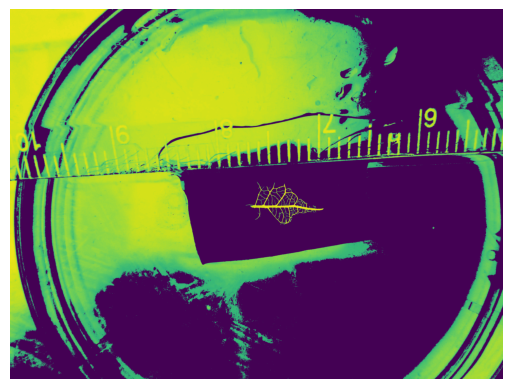

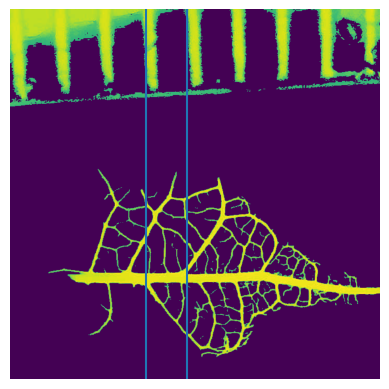

0.0125 0.023255813953488372


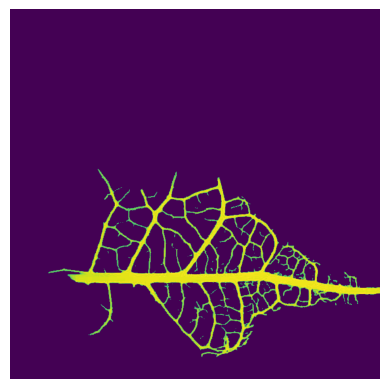

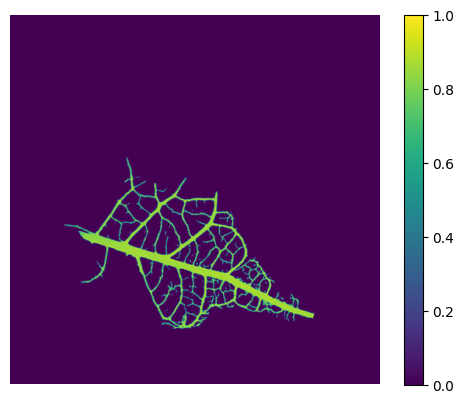

In [29]:
imgref = cv2.imread("./dataset/leaf/leaf.jpg")
imgref = cv2.cvtColor(imgref, cv2.COLOR_BGR2GRAY)
imgref = imgref / imgref.max()
imgref = 1 - imgref
imgref[imgref < 0.65] = 0.0
# imgref[imgref >= 0.6] = 1.0

plt.imshow(imgref)
plt.gca().set_axis_off()
plt.show()

wmin = 2015 - 100
wmax = 2525 + 100
# ~ 6 mm
hmin = 1150
imgref = imgref[hmin:(hmin + wmax-wmin),wmin:wmax]
plt.imshow(imgref)
plt.axvline(260) # 1 mm
plt.axvline(340) # 1 mm
plt.gca().set_axis_off()
plt.show()
imgref[:200,:] = 0

dimage = 1/(340-260)
dpa    = 2 * r / imsz
print(dimage,dpa)

plt.imshow(imgref)
plt.gca().set_axis_off()
plt.show()


sz = int((dimage/dpa) * imgref.shape[0])
imgref = cv2.resize(imgref, (sz, sz))
imgref = rotate_arb(imgref,-17) # set manually 
imgref = imgref / imgref.max()
imgref[imgref> 1] = 1
imgref[imgref< 0] = 0
plt.imshow(imgref)
plt.colorbar()
plt.gca().set_axis_off()
plt.show()

# print(imgref.mean())

def align_image(A,mipth=0.1):
    # get image, pad them to match the size
    padsz = int(np.ceil((imgref.shape[0] - imsz)/2))
    padmod = np.mod(imgref.shape[0] - imsz,2)
    A2 = A.clone()
    A2[A2 < mipth] = 0
    A2[A2 >= mipth] = 1
    A2 = np.pad(A2, (padsz,padsz))[:-padmod,:-padmod]


    ftref = np.fft.fft2(imgref)
    ftA2 = np.fft.fft2(A2)
    ft_mult = (ftref * np.conj(ftA2))
    mult = np.fft.ifft2(ft_mult)

    # Step 5: Shift the zero-frequency component to the center
    mult = abs(np.fft.ifftshift(mult))

    max_loc = np.argmax(mult)
    max_loc = np.unravel_index(max_loc, mult.shape)

    imgref_aligned = imgref[(max_loc[0] - 50):(max_loc[0] + 50),(max_loc[1] - 50):(max_loc[1] + 50)]
    return imgref_aligned

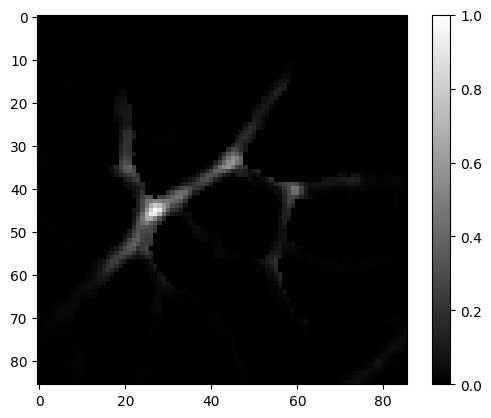

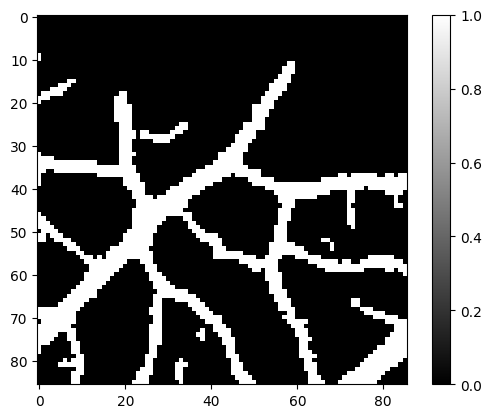

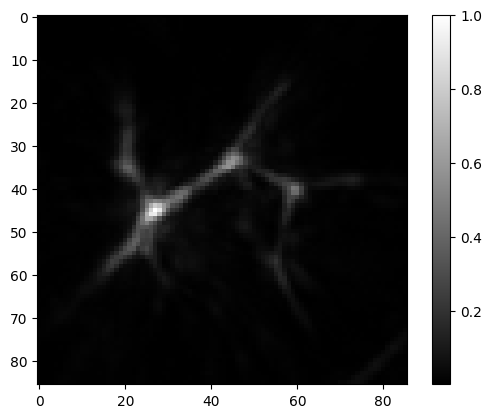

SSIM: 0.331, CNR: 0.270


In [30]:
# ref for study case
xstart =  167
ystart =  199
ref  = imgref[(ystart):(ystart+imsz),(xstart):(xstart+imsz)]
ref  = ref / ref.max()

RAW     = volPA.abs().numpy() # get this after you run the reconstruction above. THe  volPA is the yield vikume
RAW     = RAW / RAW.max()
RAWMIP  = RAW.max(-1)

# SSIM
ssimval = ssim(RAWMIP,ref,data_range=1.0)

# CNR
def calc_cnr2(im,mask):
    # mask[mask > 0] = 1
    sig = im * mask
    bg = im * (1-mask)
    
    plt.imshow(sig,cmap='gray')
    plt.colorbar()
    plt.show()

    return (sig.mean() - bg.mean()) / bg.std()

ths = 0.1
refbin = ref.copy()
refbin[refbin < ths] = 0
refbin[refbin >= ths] = 1
cnrval = calc_cnr2(RAWMIP,refbin)

plt.imshow(refbin,cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(RAWMIP,cmap='gray')
plt.colorbar()
plt.show()

print(f"SSIM: {ssimval:.3f}, CNR: {cnrval:.3f}")

# Spiral Evaluation